In [1]:
# --- Imports
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# --- Settings
sns.set_theme(style='whitegrid')
sns.set_palette('viridis')
np.random.seed(42)

In [2]:
def heatmap(degrees, lambdas, scaled_scores, title, float_precision=1, colorbar=False): #
    # recasting to imshow-format
    degrees = degrees[::-1]
    scores = scaled_scores[::-1,:]

    fig, ax = plt.subplots()
    im = ax.imshow(scores, cmap='viridis')
    if colorbar: plt.colorbar(im)
    ax.grid(False)
    ax.set_xticks(np.arange(len(lambdas)), labels=lambdas)
    ax.set_yticks(np.arange(len(degrees)), labels=degrees)
   

    # Show all ticks and label them with the respective list entries
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    
    plt.xlabel(r"$\lambda$")
    plt.ylabel("Polynomial degree")

    # Loop over data dimensions and create text annotations.
    for i in range(len(degrees)):
        for j in range(len(lambdas)):
            text = ax.text(j, i, f"{scores[i, j]:.{float_precision}f}",
                        ha="center", va="center", color='w')

    ax.set_title(title)
    fig.tight_layout()

In [3]:
def FrankeFunction(x,y): # from project description
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [4]:
def polynomial_matrix_2D(x, y, p, no_intercept=True):
	"""Variables x and y, degree p. Returns design matrix."""
	n = len(x) # number of data points
	if p == 0: return np.ones((n,1))

	l = int((p+1)*(p+2)/2) # number of elements in beta
	X = np.zeros((n,l-no_intercept))

	idx = int(not no_intercept)
	for degree in range(1,p+1):
		for ydegree in range(degree+1):
			X[:, idx] = (x**(degree - ydegree)) * (y**ydegree)
			idx += 1
		
	return X

In [5]:
# --- Generating dataset
n = 100 # the square root of the number of datapoints
x, y = np.linspace(0,1,n), np.linspace(0,1,n)
x, y = np.meshgrid(x, y)
x = x.ravel()
y = y.ravel()

k = .1 # noise coefficient
z = FrankeFunction(x,y) + k*np.random.randn(n**2) # target variable with standard normal noise

# --- Creating design matrix
p = 5 # highest polynomial degree 
N = np.arange(p+1) # for looping and plotting later
L = [int((p+1)*(p+2)/2) for p in N] # beta lengths
l = L[-1] # greatest beta length

logmin, logmax, m = -4, 0, 5 # logspce start, end, number of lambda values
llambdas = np.logspace(logmin, logmax, m)

MSE_Ridge_train, MSE_Ridge_test = np.zeros((p,m)), np.zeros((p,m))
R2_Ridge_train, R2_Ridge_test = np.zeros((p,m)), np.zeros((p,m))
beta_values = np.zeros((p+1,l,m))

for i in N:
    # Constructing the design matrix
    X = polynomial_matrix_2D(x, y, i, no_intercept=True) # degree i, no intercept

    # Splitting the data (note that y_... has nothing to do with y)
    X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.2, random_state=3)

    # Scaling the data (only centering)
    y_train_mean = np.mean(y_train)
    y_train_centered = y_train - y_train_mean
    intercept = y_train_mean # recovering intercept, which is just y_train_mean due to centering

    if i == 0: beta_values[0,0] = intercept; continue # degree 0 case

    X_train_mean = np.mean(X_train, axis=0) # 1D array of each column mean
    X_train_centered = X_train - X_train_mean
    X_test_centered = X_test - X_train_mean # centering with training data

    # -- Solving Ridge
    size = len(X[0])
    I = np.eye(size,size)
    for j, lmbd in enumerate(llambdas):
        beta = np.linalg.inv(X_train_centered.T @ X_train_centered + lmbd*I) @ X_train_centered.T @ y_train_centered

        y_tilde = X_train_centered @ beta + intercept # predictor on training data
        y_predict = X_test_centered @ beta + intercept # predictor on test data

        MSE_Ridge_train[i-1,j], MSE_Ridge_test[i-1,j] = mean_squared_error(y_tilde, y_train), mean_squared_error(y_predict, y_test)
        R2_Ridge_train[i-1,j], R2_Ridge_test[i-1,j] = r2_score(y_tilde, y_train), r2_score(y_predict, y_test)

        beta_values[i,0,j] = intercept
        beta_values[i,1:len(beta)+1,j] = beta.T

[]

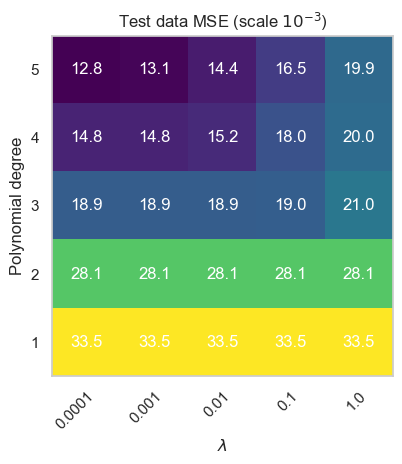

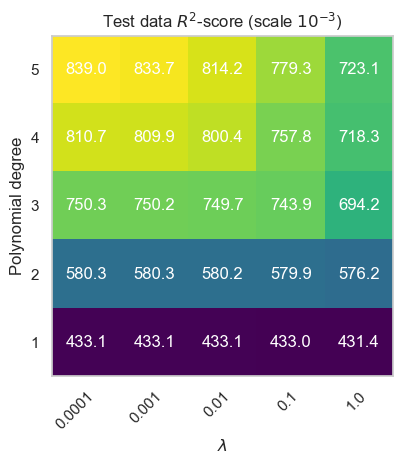

In [6]:
# Plotting OLS MSE and R2 against complexity
heatmap(N[1:], llambdas, MSE_Ridge_test*1000, r"Test data MSE (scale $10^{-3}$)")
plt.savefig("../Latex/Images/heatmap_ridge_testMSE_franke.png", bbox_inches="tight"); plt.plot()
# heatmap(N[1:], llambdas, MSE_Ridge_train*1000, r"Training data MSE (scale $10^{-3}$)")
# plt.savefig("../Latex/Images/heatmap_ridge_trainMSE_franke.png", bbox_inches="tight"); plt.plot()

heatmap(N[1:], llambdas, R2_Ridge_test*1000, r"Test data $R^2$-score (scale $10^{-3}$)", float_precision=1)
plt.savefig("../Latex/Images/heatmap_ridge_testR2_franke.png", bbox_inches="tight"); plt.plot()
# heatmap(N[1:], llambdas, R2_Ridge_train*1000, r"Training data $R^2$-score (scale $10^{-3}$)", float_precision=1)
# plt.savefig("../Latex/Images/heatmap_ridge_trainR2_franke.png", dpi=100, bbox_inches='tight', facecolor='w'); plt.plot()

# --- Separate plots
# for i, lmbd in enumerate(llambdas):
#     plt.plot(N[1:], MSE_Ridge_train[:,i], 'o-', label='train')
#     plt.plot(N[1:], MSE_Ridge_test[:,i], 'o-', label='test')
#     plt.title(r"$\lambda = $" + f"{lmbd}")
#     plt.legend(); plt.show()

#     plt.plot(N[1:],R2_Ridge_train[:,i], 'o-', label='train')
#     plt.plot(N[1:],R2_Ridge_test[:,i], 'o-', label='test')
#     plt.title(r"$\lambda = $" + f"{lmbd}")
#     plt.legend(); plt.show()

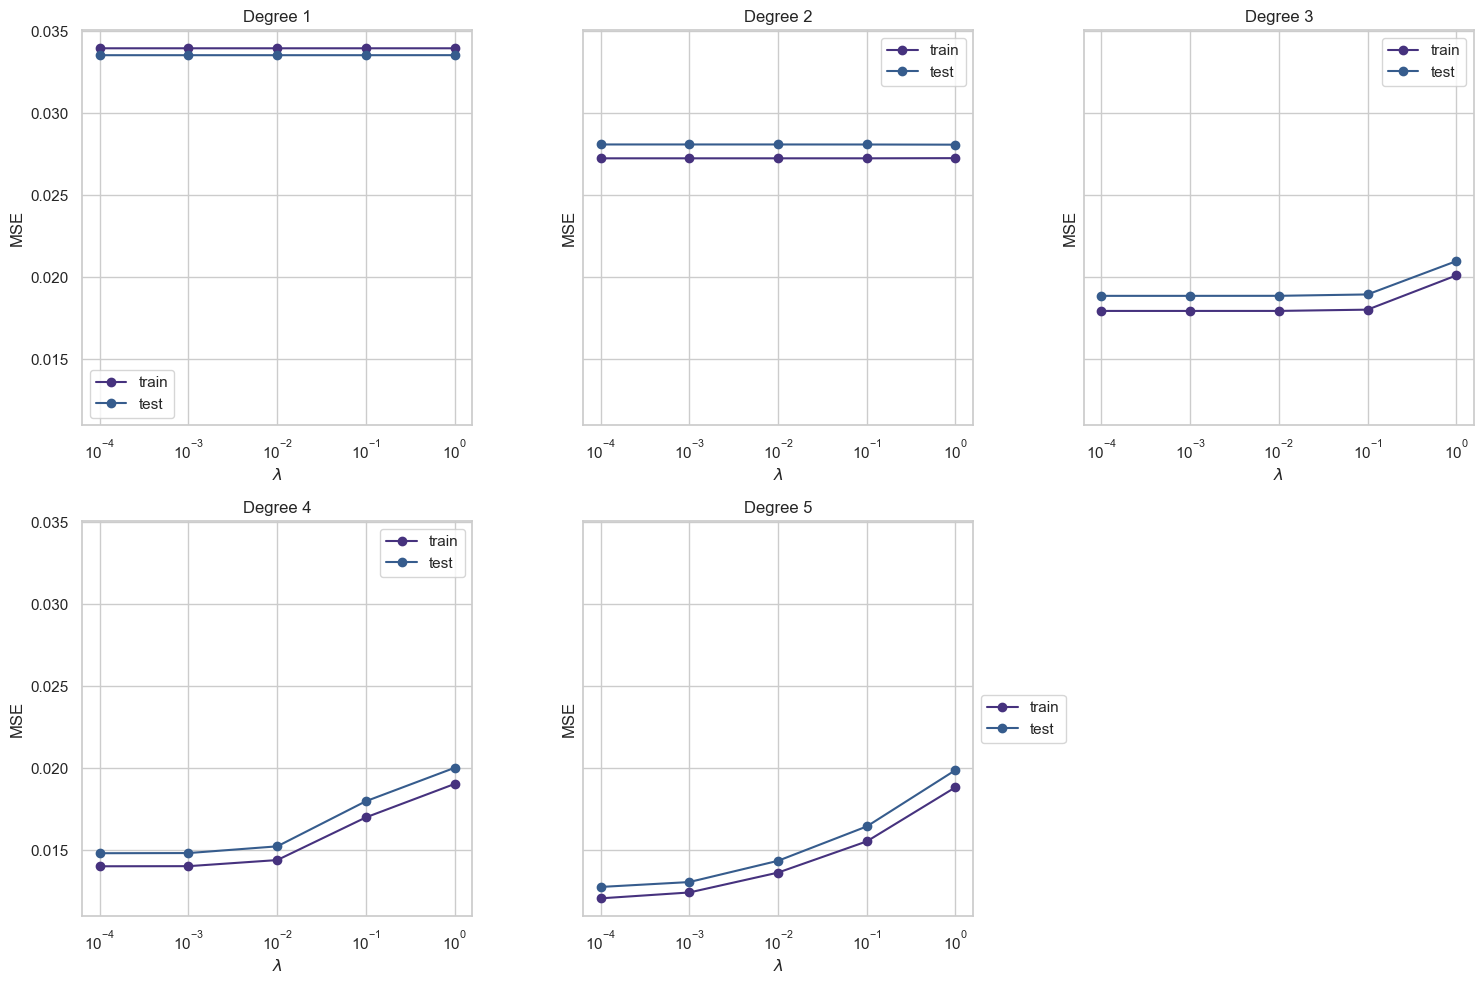

In [7]:
# Plotting OLS MSE and R2 against complexity

fig, axs = plt.subplots(2, 3, figsize=(15, 5 * 2), sharey=True)

for idx, deg in enumerate(N[1:], 1):
    row = (idx - 1) // 3
    col = (idx - 1) % 3
    ax = axs[row, col]
    ax.plot(llambdas, MSE_Ridge_train[deg-1, :], 'o-', label='train')
    ax.plot(llambdas, MSE_Ridge_test[deg-1, :], 'o-', label='test')
    ax.set_title(rf"Degree {deg}")
    ax.legend()
    ax.set_xlabel(r'$\lambda$')
    ax.set_ylabel('MSE')
    ax.set_xscale('log')  # Set x-axis to logarithmic scale

# Turn off any unused subplots
for i in range(idx, 2 * 3):
    fig.delaxes(axs[i // 3, i % 3])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True)

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


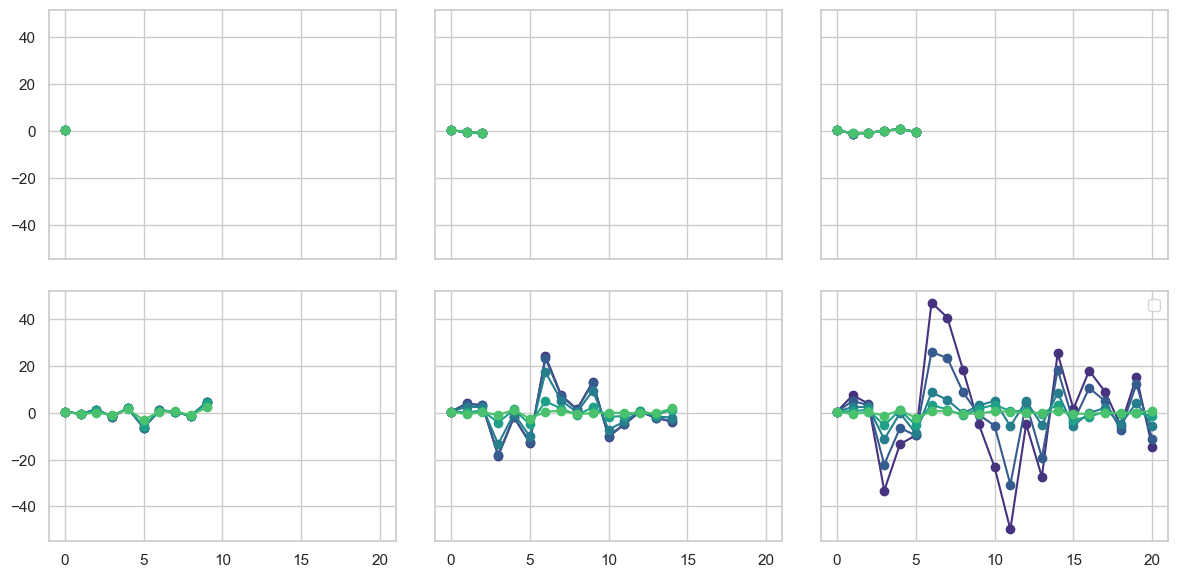

In [29]:
# Plotting beta coefficients - could be prettier
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True); fig.tight_layout()
axs = axs.flatten()

for i,l in enumerate(L):
    a = axs[i].plot(np.arange(l), beta_values[i][:l], 'o-')

#fig.colorbar(a, cax=axs)
plt.legend()
plt.show()

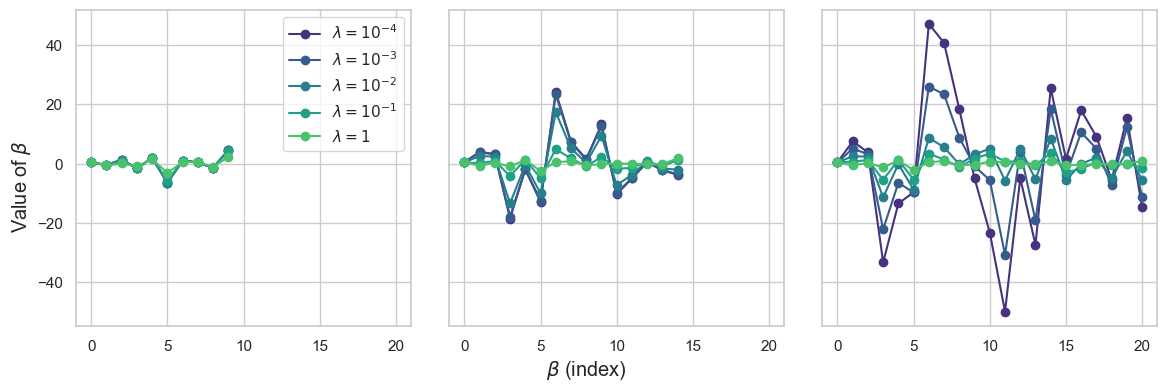

In [32]:
# Plotting all beta coefficients - could be prettier
fig, axs = plt.subplots(1,3, figsize=(12, 4), sharex=True, sharey=True); fig.tight_layout()
axs = axs.flatten()

legend_vals = [r'$\lambda = 10^{-4}$', r'$\lambda = 10^{-3}$', r'$\lambda = 10^{-2}$', 
               r'$\lambda = 10^{-1}$', r'$\lambda = 1$']

for i,l in enumerate(L):
    if i < 3: continue
    axs[i-3].plot(np.arange(l), beta_values[i][:l], 'o-', label=legend_vals)
    if i == 3:
        axs[i-3].legend(loc='best')


fig.supxlabel(r'$\beta$ (index)')
fig.supylabel(r'Value of $\beta$')

plt.subplots_adjust(left=0.075, bottom=0.15)
plt.show()